### Import libraries

In [13]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imghdr

### Limit the amount of GPU ram being used

In [14]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

## Remove images that are not good

In [16]:
from PIL import Image

data_dir = 'data/train'

def verify_image(image_path):
    try:
        im = Image.open(image_path)
        im.verify()
        im.close()
        return
        # DEBUG: print(f"OK: {f}")
    except (IOError, OSError, Image.DecompressionBombError):
        print('Issue with image {}'.format(image_path))
        os.remove(image_path)
        return

image_exts = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        print(image_path)
        verify_image(image_path)





# for image_class in os.listdir(data_dir):
#     for image in os.listdir(os.path.join(data_dir, image_class)):
#         image_path = os.path.join(data_dir, image_class, image)
#         try:
#             img = Image.open(image_path)
#             img.verify()
#             img.close()
#             # tip = imghdr.what(image_path)
#             # if tip not in image_exts:
#             #     print('Image not in ext list {}'.format(image_path))
#             #     os.remove(image_path)
#         except:
#             print('Issue with image {}'.format(image_path))
#             # os.remove(image_path)

data/train/drawings/19a6c8ce-e600-498d-b57e-8b1de6cbe8c6.jpg
data/train/drawings/58ecfa96-6513-4bbe-98f0-ffa9af65791c.jpg
data/train/drawings/37325e6f-1806-4d55-bbcb-5dd0a03b68b4.jpg
data/train/drawings/798f026a-917f-40b1-8ec8-6e42a2654310.jpg
data/train/drawings/4fdeac67-750e-4ead-83d6-28ed921e6c83.jpg
data/train/drawings/931b3a57-af47-4c38-adf5-50a4bc57ff0e.jpg
data/train/drawings/119e5296-db28-4f17-9b91-a3614fc455ae.jpg
data/train/drawings/f78367ef-7ed5-48e0-85c6-e139da81ee50.jpg
data/train/drawings/f63d2934-5951-438a-8fd7-b80079dc2029.jpg
data/train/drawings/0588144a-90fb-405e-a101-38fcd90f248e.jpg
data/train/drawings/34588c76-8752-4cc0-a8f5-98c241839749.jpg
data/train/drawings/f247170a-67d5-4961-9a29-fd62f8ce8bfa.jpg
data/train/drawings/c9cb1391-1803-4315-9b4d-d4f4ca931a18.jpg
data/train/drawings/8ab3cc69-89db-433d-811d-9527ef59670a.jpg
data/train/drawings/b3f56314-9788-4612-9058-b2c5ad163895.jpg
data/train/drawings/144156d3-97c0-4e60-8b30-f8a45b24aced.jpg
data/train/drawings/081b

### Load Data

Use tensorflow because it has a dataset API.
It will allow us to build data pipilines to scale on larger datasets

In [17]:
tf.keras.utils.image_dataset_from_directory??

In [50]:
"""
image_dataset does some preproceessing for us:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
"""
# Made a folder called data that generates
data = tf.keras.utils.image_dataset_from_directory('data/train')

Found 40940 files belonging to 4 classes.


In [51]:
# Allows use to access our data pipiline
data_iterator = data.as_numpy_iterator()

In [52]:
# Get us a data batch
# We can rerun this line to get a new batch
batch = data_iterator.next()

In [53]:
# Returns us an image and the labels in the form of a tuple
batch[0].shape  # (32, 256, 256, 3) batch size of 32 with a image dim of 256 256 in 3 colours (RGB)

(32, 256, 256, 3)

In [54]:
# The labels of our images where 1 represents
batch[1]

array([1, 2, 0, 1, 3, 2, 2, 2, 3, 1, 1, 2, 1, 1, 3, 3, 3, 0, 3, 3, 3, 2,
       2, 2, 0, 3, 0, 3, 1, 3, 3, 1], dtype=int32)

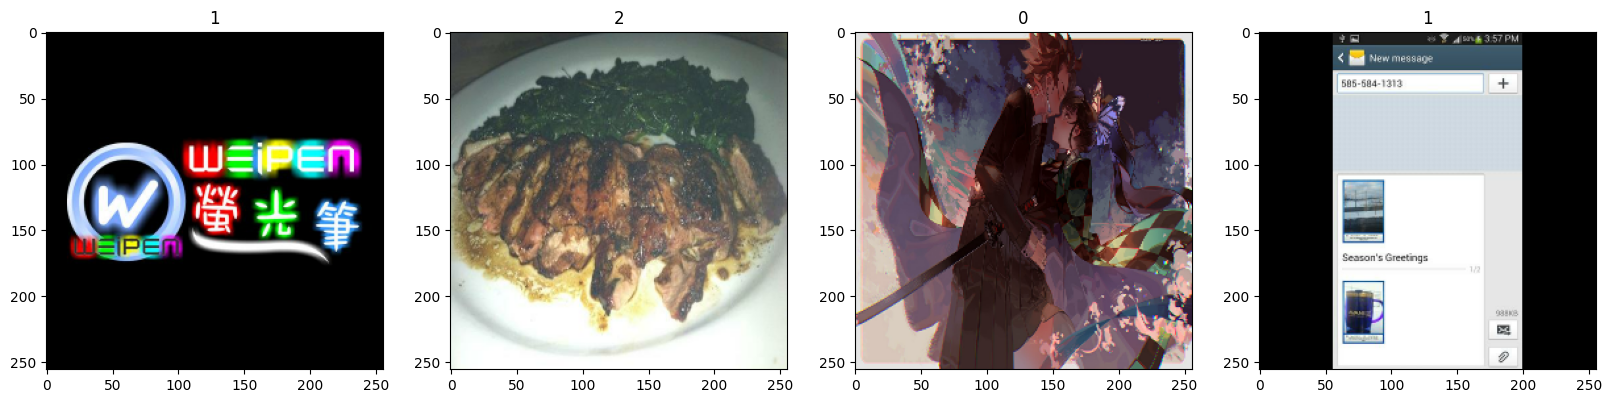

In [55]:
# drawings = class 0
# memes = class 1
# neutral = class 2
# porn = class 3
# We can check which labels represents which class:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))  # subplots to plot 10 images at a time
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Scale the data so that the image values be between 0 and 1. This helps produce quicker results

In [24]:
# Map allows us to transform the data in the pipeline
data = data.map(lambda x, y: (x / 255, y))
# We only divide x by 255 because that is where the rgb colours are located

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [25]:
# Looking at the values now, they are between 0 and 1
data.as_numpy_iterator().next()[0]

array([[[[0.23137255, 0.23921569, 0.1882353 ],
         [0.23529412, 0.24313726, 0.19215687],
         [0.23174019, 0.23958333, 0.18860294],
         ...,
         [0.23624387, 0.22840074, 0.17742035],
         [0.24108456, 0.23324142, 0.18226103],
         [0.24108456, 0.23324142, 0.18226103]],

        [[0.2276348 , 0.23547794, 0.18449755],
         [0.23433311, 0.24217625, 0.19119586],
         [0.23835953, 0.24620266, 0.19522226],
         ...,
         [0.24463849, 0.23679534, 0.18581495],
         [0.24313726, 0.23529412, 0.18431373],
         [0.24313726, 0.23529412, 0.18431373]],

        [[0.22539829, 0.23324142, 0.18226103],
         [0.23155637, 0.23939951, 0.18841912],
         [0.23621324, 0.24405637, 0.19307598],
         ...,
         [0.24556501, 0.23772188, 0.18674149],
         [0.24705882, 0.23921569, 0.1882353 ],
         [0.24705882, 0.23921569, 0.1882353 ]],

        ...,

        [[0.06666667, 0.05098039, 0.04475193],
         [0.06666667, 0.05202038, 0.03817569]

### Lets split the training folder into train and evaluation

In [26]:
# We have 1489 batches and each batch has 32 images
len(data)

1280

From the training dataset, we are setting the train size to be 70% and the evaluation size to be 30%

In [27]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.3) # We are going to evaluate our model as we train
# test_size = int(len(data)*.1) # We have our own test set that will be used at the end
print(train_size)
print(val_size)

896
384


In [28]:
# take tells us how much data we are going to take from that partition
train = data.take(train_size) # We are taking 1042 batches * 32 images for our training
# whatever that was used in the train cannot be used in the evaluation partition therefore we skip it
val = data.skip(train_size).take(val_size) # We are taking 446 batches * 32 images for our evaluation
# Note: our data is being shuffled already by image_dataset_from_directory

## Building the model:


In [29]:
# Sequential API is used for a linear data pipeline
from tensorflow.python.keras.models import Sequential
# These are the layers we will be using
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [30]:
model = Sequential()

In [17]:
MaxPooling2D??

In [31]:
# These are our hyperparameters:
# conv2D : with feature extraction we can expect higher accuracy
    # 1st param: make 16 different filters
    # 2nd param: kernel size is 3x3
    # 3rd param: this will be the stride, going from one pixel to the next
    # 4th param: activation function. Any values below 0 will become 0 and anything above will be preserved (helps with non linear patterns)
    # 5th param: input_shape 256 pixels x 256 pixels with 3 channels
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3))) # This is the first layer which is the input
# pooling layer, takes the max value from relu activation and condenses it down to half
""" Default values for MaxPooling2D:
               pool_size=(2, 2),
               strides=None,
               padding='valid',
               data_format=None"""
model.add(MaxPooling2D())

# It is okay to repeat [Conv-Pooling] several times
# we will repeat [Conv-Pooling] two more times to increase learning effect
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# Flatten the data down into a single value
model.add(Flatten())

model.add(Dense(256, activation='relu')) # These are teh fully connected layers (256 neurons)
model.add(Dense(4, activation='softmax')) # The final connected layers are between 0 and 3 which represent our class numbers

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0

In [33]:
# Using the adam optimizer but there are maybe different ones
# Since we have multiple classes we will use sparse_categorical_crossentropy
# We want to track the accuracy of our model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train the model

In [34]:
# Creating a log folder
logdir="logs"

In [35]:
# Useful to save the model at a certain point or for logging
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [36]:

# We will now train the model
# 1 Epoch is one over the entire training set of data
# We then evaluate how well the training is going
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5


2022-11-28 18:51:14.515734: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 132128768 exceeds 10% of free system memory.
2022-11-28 18:51:15.429723: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 132128768 exceeds 10% of free system memory.


  1/896 [..............................] - ETA: 51:42 - loss: 1.3871 - accuracy: 0.4375

2022-11-28 18:51:15.783251: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 132128768 exceeds 10% of free system memory.
2022-11-28 18:51:15.994691: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 144265173 exceeds 10% of free system memory.
2022-11-28 18:51:16.654585: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 132128768 exceeds 10% of free system memory.


 47/896 [>.............................] - ETA: 14:06 - loss: 1.1594 - accuracy: 0.5226

KeyboardInterrupt: 

### Results

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()